In [1252]:
import torch
import torchvision

import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import os
import cv2



MODEL_PATH = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/CODE/Pretrainedcontrastive/tenpercent_resnet18.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False

#use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = torchvision.models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location='cpu')

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)


In [1253]:
# model = model #.cuda()
images = torch.rand((10, 3, 224, 224))  #device='cuda'
out = model(images)

print(out.shape) # [10,512]
# print(model)
# print(out)

torch.Size([10, 512])


In [1254]:

class HistoBags(Dataset):
    def __init__(self, seed=1, train=True):
        self.train = train
        self.r = np.random.RandomState(seed)

        if self.train:
            self.train_bags_list, self.train_labels_list = self._create_bags()
        else:
            self.test_bags_list, self.test_labels_list = self._create_bags()


    def _load_images_from_folder(self,folder):
        images = []
        count = 0
        for filename in os.listdir(folder):
            
            
            if count >= 2000:
                break
            img = cv2.imread(
                os.path.join(folder, filename))  # by default OpenCV reads image in the sequence Blue Green Red (BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img/255
            if img is not None:
                images.append(img)
            count += 1

        images = np.stack(images, axis=0)
        images = torch.from_numpy(images).float()
        images = images.permute(0, 3, 1, 2)
        print(images.shape)
        return images

    #creates a bag and label list out of the out of normalised MNIST images
    def _create_bags(self):
        bags_list = []
        labels_list = []

        if self.train:
            # normal train images
            # camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/processed_normal_00'
            # # camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/preprocesseddata/train/normal_'
            # for i in range(2, 3):
            #     path = camelyondir + str(i)
            #     print(os.path.exists(path))
            #     images = self._load_images_from_folder(path)
            #     bags_list.append(images)
            #     labels_list.append(torch.tensor([0]))

            # tumor train images
            camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/processed_tumor_00'
            # camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/preprocesseddata/train/tumor_'
            for i in range(1, 2):
                path = camelyondir + str(i)
                print(os.path.exists(path))
                images = self._load_images_from_folder(path)
                bags_list.append(images)
                labels_list.append(torch.tensor([1]))
        else:
            # tumor test images
            camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/processed_tumor_00'
            for i in range(2, 2):
                path = camelyondir + str(i)
                print(os.path.exists(path))
                images = self._load_images_from_folder(path)
                bags_list.append(images)
                labels_list.append(torch.tensor([1]))

        return bags_list, labels_list

    #returns lenght of train or test set
    def __len__(self):
        if self.train:
            return len(self.train_labels_list)
        else:
            return len(self.test_labels_list)

    #returns a certain bag and its label
    def __getitem__(self, index):
        if self.train:
            bag = self.train_bags_list[index]
            label = self.train_labels_list[index]
        else:
            bag = self.test_bags_list[index]
            label = self.test_labels_list[index]

        return bag, label


In [1255]:
train_loader = DataLoader(HistoBags(seed=1,train=True),
                                         batch_size=1,
                                         shuffle=True)

True
torch.Size([2000, 3, 224, 224])


In [1256]:
for batch_idx, (data, label) in enumerate(train_loader):
    print(data.shape)
    data = data.squeeze(0)
    embeddings = model(data)
    print(embeddings.shape)

torch.Size([1, 2000, 3, 224, 224])
torch.Size([2000, 512])


In [1257]:
from sklearn.cluster import MiniBatchKMeans

In [1258]:
kmeans = MiniBatchKMeans(n_clusters=250,
                          random_state=5,
                          batch_size=100,
                          max_iter=10).fit(embeddings.detach().numpy() )

# n_clusters=8, *, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True, random_state=None,
# tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)[source]¶

In [1259]:
kmeans.cluster_centers_

array([[0.20452178, 0.16909543, 0.22996315, ..., 0.3897544 , 0.12765792,
        0.43755454],
       [0.20726942, 0.15105534, 0.16131508, ..., 0.187052  , 0.2030715 ,
        0.05440712],
       [0.7795101 , 0.17945533, 0.04997486, ..., 0.21597038, 0.1828986 ,
        0.10144448],
       ...,
       [0.17917901, 0.41462663, 0.26264492, ..., 0.36503118, 0.577291  ,
        0.46560577],
       [0.23199344, 0.17379709, 0.30668554, ..., 0.27555487, 0.18081239,
        0.14230649],
       [0.25331342, 0.31163156, 0.18441106, ..., 0.23142058, 0.36708164,
        0.2588077 ]], dtype=float32)

In [1260]:
kmeans.cluster_centers_.shape

(250, 512)

In [1261]:
clustering_list = kmeans.fit_predict(embeddings.detach().numpy())
kmeans.fit_predict(embeddings.detach().numpy())

array([ 16, 105, 195, ..., 242,   0, 233], dtype=int32)

In [1262]:
def load_images_from_folder(folder):
        images = []
        count = 0
        for filename in os.listdir(folder):
            if count >= 2000:
                break
            img = cv2.imread(
                os.path.join(folder, filename))  # by default OpenCV reads image in the sequence Blue Green Red (BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img/255
            if img is not None:
                images.append(img)
            count += 1

        images = np.stack(images, axis=0)
        images = torch.from_numpy(images).float()
        images = images.permute(0, 3, 1, 2)
        return images

camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/processed_tumor_00'
        # camelyondir = '/Users/imac/Documents/Documents_Pieter_MacBook_Pro/0MasterAI/THESIS/data/CAMELYON/preprocesseddata/train/tumor_'
for i in range(1, 2):
    path = camelyondir + str(i)
    print(os.path.exists(path))
    images = load_images_from_folder(path)


True


In [1263]:
imagegroup = []
imagegroup2 = []
imagegroup3 = []
imagegroup4 = []
imagegroup5 = []
imagegroup6 = []
imagegroup7 = []
imagegroup8 = []
imagegroup9 = []
imagegroup10 = []
imagegroup11 = []
imagegroup12 = []
imagegroup13 = []
imagegroup14 = []
imagegroup15 = []
imagegroup16= []
imagegroup17 = []


for index,clusternumber in enumerate(clustering_list):
    if clusternumber ==1:
        imagegroup.append(images[index])
    if clusternumber ==2:
        imagegroup2.append(images[index])
    if clusternumber ==3:
        imagegroup3.append(images[index])
    if clusternumber ==4:
        imagegroup4.append(images[index])
    if clusternumber ==5:
        imagegroup5.append(images[index])
    if clusternumber ==6:
        imagegroup6.append(images[index])
    if clusternumber ==7:
        imagegroup7.append(images[index])
    if clusternumber ==8:
        imagegroup8.append(images[index])
    if clusternumber ==9:
        imagegroup9.append(images[index])
    if clusternumber ==10:
        imagegroup10.append(images[index])
    if clusternumber ==11:
        imagegroup11.append(images[index])
    if clusternumber ==12:
        imagegroup12.append(images[index])
    if clusternumber ==13:
        imagegroup13.append(images[index])
    if clusternumber ==14:
        imagegroup14.append(images[index])
    if clusternumber ==15:
        imagegroup15.append(images[index])
    if clusternumber ==16:
        imagegroup16.append(images[index])
    if clusternumber ==17:
        imagegroup17.append(images[index])
    
        
    

In [1264]:
len(imagegroup)

25

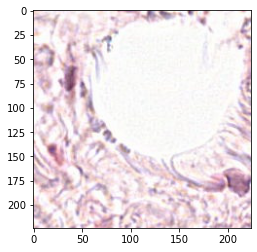

In [1265]:
# plt.figure(figsize = (4,4))
plt.imshow(imagegroup[0].permute(1, 2, 0)  )


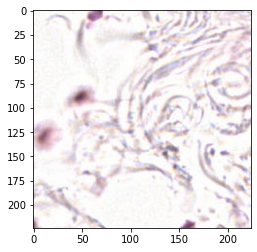

In [1266]:
plt.imshow(imagegroup[1].permute(1, 2, 0)  )

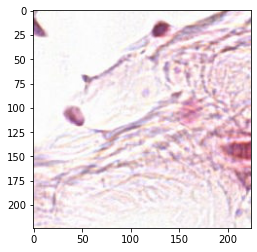

In [1267]:
plt.imshow(imagegroup[2].permute(1, 2, 0)  )

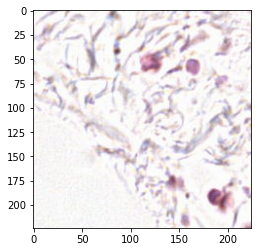

In [1268]:
plt.imshow(imagegroup[3].permute(1, 2, 0)  )

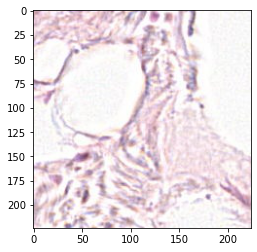

In [1269]:
plt.imshow(imagegroup[4].permute(1, 2, 0)  )

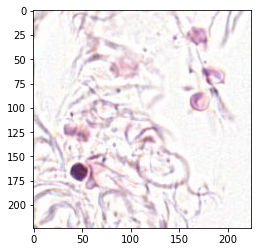

In [1270]:
plt.imshow(imagegroup[5].permute(1, 2, 0)  )

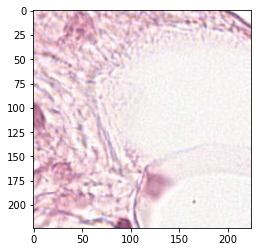

In [1271]:
plt.imshow(imagegroup[6].permute(1, 2, 0)  )

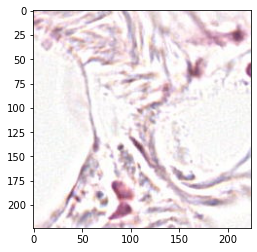

In [1272]:
plt.imshow(imagegroup[7].permute(1, 2, 0)  )

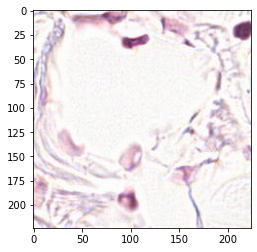

In [1273]:
plt.imshow(imagegroup[8].permute(1, 2, 0)  )

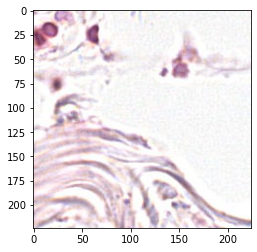

In [1274]:
plt.imshow(imagegroup[9].permute(1, 2, 0)  )

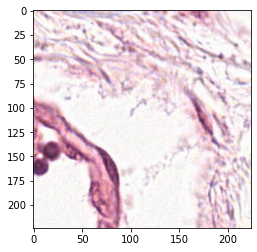

In [1275]:
plt.imshow(imagegroup[11].permute(1, 2, 0)  )

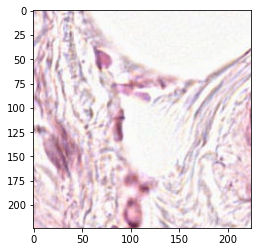

In [1276]:
plt.imshow(imagegroup[10].permute(1, 2, 0)  )

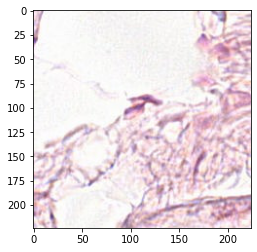

In [1277]:
plt.imshow(imagegroup[12].permute(1, 2, 0)  )

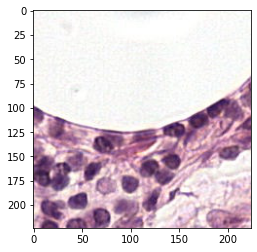

In [1278]:
plt.imshow(imagegroup2[0].permute(1, 2, 0)  )

In [1279]:
plt.imshow(imagegroup2[1].permute(1, 2, 0)  )

IndexError: list index out of range

In [ ]:
plt.imshow(imagegroup2[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup2[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup2[5].permute(1, 2, 0)  )

In [ ]:
imagegroup3

In [ ]:
plt.imshow(imagegroup3[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[7].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup3[8].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup4[7].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup5[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup5[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup5[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup5[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup6[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup6[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup6[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup6[3].permute(1, 2, 0)  )

In [ ]:

plt.imshow(imagegroup7[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup7[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup7[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup7[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[1].permute(1, 2, 0)  )


In [ ]:
plt.imshow(imagegroup8[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup9[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup10[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup10[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup10[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup11[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup12[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup13[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup13[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup13[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup13[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[7].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup14[8].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup15[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup15[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[5].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[6].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[7].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[8].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[9].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[10].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[11].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup16[12].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup17[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup17[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup17[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup17[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[0].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[1].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[2].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[3].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )

In [ ]:
plt.imshow(imagegroup8[4].permute(1, 2, 0)  )